## Solution Steps: 

1. Data access
2. Data exploration (initial data analysis)  
   2.1. Exploration of features and target distribution  
3. Data Preparation  
   3.1. Clean the data  
   3.2. Filter important features  
   3.3. Check for missing values     
   3.4. Feature engineering (feature extraction, feature selection)  
4. Train the model
5. Use the model (Prediction)
6. Evaluate the model (accuracy)

## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore,norm
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import random
import pickle
import warnings
warnings.filterwarnings('ignore')

## **Data Access** ##

We have two main datasets, **Ancients** and **Moderns**.

 Ancient genomes from Europe and Asia are found in Ancients, while Eurasian genomes with a DataBP of 10 are found in Moderns.

**Note:** 
Dataset files should be available in the data folder (Eurasian.xlsx, Eurasian_modern_samples.csv, 20130606_sample_info.xlsx, and Test Cases.xlsx). 

In [2]:
baseDir='data'
#ancient samples
dataset =  pd.ExcelFile(f"{baseDir}/Eurasian - Dataset_tims.xlsx")
Eurasian = pd.read_excel(dataset, 'Eurasian')
Ancients = Eurasian[[ 'AncientComponent1', 'AncientComponent2','AncientComponent3', 'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                'ModernComponent2', 'ModernComponent3', 'Date mean in BP in years before 1950 CE [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]'
                ,'Method for Determining Date; unless otherwise specified, calibrations use 95.4% intervals from OxCal v4.4.2 Bronk Ramsey (2009); r:5; Atmospheric data from Reimer et al (2020)'
                , 'Sample ID', 'Country'
                ,'Date standard deviation in BP [OxCal sigma for a direct radiocarbon date, and standard deviation of the uniform disribution between the two bounds for a contextual date]'              
]]

Ancients.rename(columns={
    'Method for Determining Date; unless otherwise specified, calibrations use 95.4% intervals from OxCal v4.4.2 Bronk Ramsey (2009); r:5; Atmospheric data from Reimer et al (2020)':'Dating',
    'Date standard deviation in BP [OxCal sigma for a direct radiocarbon date, and standard deviation of the uniform disribution between the two bounds for a contextual date]':'STD',
    'Date mean in BP in years before 1950 CE [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]':'Mean date (BP)'
},inplace=True)

# modern samples (DateBP = 10)
modern = pd.read_csv(f"{baseDir}/Eurasian_modern_samples.csv")
modern = modern[[ 'AncientComponent1', 'AncientComponent2','AncientComponent3','AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                                'ModernComponent2','ModernComponent3', 'DateBP', 'Sample ID']] 
modern.rename(columns = {'DateBP':'Mean date (BP)'}, inplace=True) 

#modern samples' annotation
modern_annotation = pd.read_excel(f"{baseDir}/20130606_sample_info.xlsx")
modern_annotation.rename(columns = {'Sample':'Sample ID'}, inplace=True) 
modern_annotation.rename(columns = {'Population':'Country'}, inplace=True) 
Moderns = pd.merge(modern_annotation, modern, on=["Sample ID"])
Moderns['Dating'] = np.nan
Moderns = Moderns[['AncientComponent1', 'AncientComponent2','AncientComponent3', 'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                'ModernComponent2', 'ModernComponent3', 'Mean date (BP)', 'Dating', 'Sample ID', 'Country']]

#test_cases
test_cases = pd.ExcelFile(f"{baseDir}/Test Cases.xlsx")
Brandysek_inds = pd.read_excel(test_cases, 'Brandysek inds')
Brandysek_inds = Brandysek_inds.iloc[0:14,:]
Brandysek_inds.rename(columns={'Version ID':'Sample ID'},inplace=True)

Moderns['STD'] = 0 

## **Data Exploration (Initial Data Analysis)** ##

In [3]:
print(Ancients.info())
display(Ancients.head(3))
print(Moderns.info())
display(Moderns.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4158 entries, 0 to 4157
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AncientComponent1  4158 non-null   float64
 1   AncientComponent2  4158 non-null   float64
 2   AncientComponent3  4158 non-null   float64
 3   AncientComponent4  4158 non-null   float64
 4   AncientComponent5  4158 non-null   float64
 5   ModernComponent1   4158 non-null   float64
 6   ModernComponent2   4158 non-null   float64
 7   ModernComponent3   4158 non-null   float64
 8   Mean date (BP)     4158 non-null   int64  
 9   Dating             4158 non-null   object 
 10  Sample ID          4158 non-null   object 
 11  Country            4158 non-null   object 
 12  STD                4158 non-null   int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 422.4+ KB
None


,AncientComponent1,AncientComponent2,AncientComponent3,AncientComponent4,AncientComponent5,ModernComponent1,ModernComponent2,ModernComponent3,Mean date (BP),Dating,Sample ID,Country,STD
0,0.000011,0.000010,0.999929,0.000010,0.00001,0.000010,0.00001,0.000010,5162,Direct: IntCal20,I1658,Armenia,80
1,0.243402,0.025254,0.009610,0.136992,0.00001,0.009278,0.56163,0.013823,5166,Direct: IntCal20,1H07.SG,France,79
2,0.255344,0.017537,0.000010,0.095890,0.00001,0.011373,0.60052,0.019316,4950,Direct: IntCal20,1H13.SG,France,53


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1306
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AncientComponent1  1307 non-null   float64
 1   AncientComponent2  1307 non-null   float64
 2   AncientComponent3  1307 non-null   float64
 3   AncientComponent4  1307 non-null   float64
 4   AncientComponent5  1307 non-null   float64
 5   ModernComponent1   1307 non-null   float64
 6   ModernComponent2   1307 non-null   float64
 7   ModernComponent3   1307 non-null   float64
 8   Mean date (BP)     1307 non-null   int64  
 9   Dating             0 non-null      float64
 10  Sample ID          1307 non-null   object 
 11  Country            1307 non-null   object 
 12  STD                1307 non-null   int64  
dtypes: float64(9), int64(2), object(2)
memory usage: 143.0+ KB
None


,AncientComponent1,AncientComponent2,AncientComponent3,AncientComponent4,AncientComponent5,ModernComponent1,ModernComponent2,ModernComponent3,Mean date (BP),Dating,Sample ID,Country,STD
0,0.066929,0.040100,0.003131,0.035866,0.014960,0.001272,0.822988,0.014754,10,NaN,HG00096,GBR,0
1,0.073446,0.047749,0.002356,0.030496,0.007208,0.005035,0.819372,0.014338,10,NaN,HG00097,GBR,0
2,0.066791,0.052471,0.000010,0.031622,0.013156,0.003371,0.826157,0.006421,10,NaN,HG00099,GBR,0


((array([-3.58788103, -3.34962434, -3.21815727, ...,  3.21815727,
          3.34962434,  3.58788103]),
  array([  90,  124,  126, ..., 9933, 9952, 9992], dtype=int64)),
 (1952.546304163356, 3925.416305916306, 0.9865907741315159))

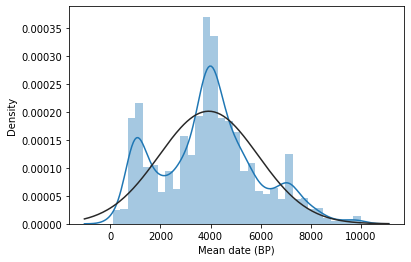

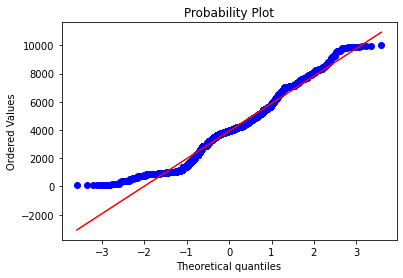

In [4]:
sns.distplot(Ancients['Mean date (BP)'], fit = norm) # A frequency distribution plot and the maximum likelihood Gaussian distribution fit
fig = plt.figure()
stats.probplot(Ancients['Mean date (BP)'], plot=plt) # It generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default).

## **Clean the Data**

In [5]:
def outlier_by_zscore(df:pd.DataFrame,column,outliers):
    df['is_outlier'] = zscore(df[column])
    is_outlier = df['is_outlier'].apply(lambda x: x <= -3 or x >= 3)
    df.drop('is_outlier',axis=1,inplace=True)
    return df[~is_outlier],outliers.append(df[is_outlier])

def preprocess(df:pd.DataFrame,outliers):
    df,outliers = outlier_by_zscore(df,'Mean date (BP)',outliers)
    df,outliers = outlier_by_zscore(df,'AncientComponent1',outliers)  
    df,outliers = outlier_by_zscore(df,'AncientComponent2',outliers)
    df,outliers = outlier_by_zscore(df,'AncientComponent3',outliers) 
    df,outliers = outlier_by_zscore(df,'AncientComponent4',outliers)
    df,outliers = outlier_by_zscore(df,'AncientComponent5',outliers)
    df,outliers = outlier_by_zscore(df,'ModernComponent1',outliers)
    df,outliers = outlier_by_zscore(df,'ModernComponent2',outliers)
    df,outliers = outlier_by_zscore(df,'ModernComponent3',outliers)

    outliers11 = df[df.STD >= 400]
    outliers = outliers.append(outliers11)
    df = df[df.STD <400]
    return df,outliers
outliers:pd.DataFrame = pd.DataFrame()
Ancients,outliers = preprocess(Ancients,outliers)


## **Check for Missing Values** 

In [6]:
print(Ancients.isnull().sum()) # No missing values are found
print(Moderns.isnull().sum()) # No missing values are found, Their Datings are intentionally left blank.

AncientComponent1    0
AncientComponent2    0
AncientComponent3    0
AncientComponent4    0
AncientComponent5    0
ModernComponent1     0
ModernComponent2     0
ModernComponent3     0
Mean date (BP)       0
Dating               0
Sample ID            0
Country              0
STD                  0
dtype: int64
AncientComponent1       0
AncientComponent2       0
AncientComponent3       0
AncientComponent4       0
AncientComponent5       0
ModernComponent1        0
ModernComponent2        0
ModernComponent3        0
Mean date (BP)          0
Dating               1307
Sample ID               0
Country                 0
STD                     0
dtype: int64


## **Feature Engineering**

In [7]:
#creating new columns based on the values of existing ones
Ancients['mean_Ancient_columns'] = Ancients.loc[:,['AncientComponent1',	'AncientComponent2',	'AncientComponent3',	'AncientComponent4',	'AncientComponent5']].mean(axis=1)  
AncientComponent1_mean = Ancients['AncientComponent1'].mean()
Ancients['AncientComponent1_diff_mean'] = abs(Ancients['AncientComponent1'] - AncientComponent1_mean)  
Ancients['AncientComponent1'] = Ancients['AncientComponent1']+(3*Ancients['AncientComponent1_diff_mean'])

Moderns['mean_Ancient_columns'] = Moderns.loc[:,['AncientComponent1',	'AncientComponent2',	'AncientComponent3',	'AncientComponent4',	'AncientComponent5']].mean(axis=1)     
Moderns['AncientComponent1_diff_mean'] = abs(Moderns['AncientComponent1'] - AncientComponent1_mean)
Moderns['AncientComponent1'] = Moderns['AncientComponent1']+(3*Moderns['AncientComponent1_diff_mean'])

## **Split the Data**

 ## **Train_set, Test_set (unseen)**

In [8]:
#set aside test cases as an unseen set
Brandysek_inds_in_Ancients = Ancients[Ancients["Sample ID"].isin(Brandysek_inds["Sample ID"].values)]
Ancients = Ancients.drop(Brandysek_inds_in_Ancients.index)

# To get a better result, we stratified the dataset, so we need to add a few more columns.
# create temporary columns
Ancients['cut'] = pd.qcut(Ancients['Mean date (BP)'], q = 10, duplicates= 'drop',labels=False, precision = 0) #df was divided into 10 subsets based on DateBP column.
Ancients['Country_cut'] = Ancients['cut'].astype(str) + Ancients['Country'].astype(str)
count_freq = dict(Ancients['Country_cut'].value_counts())
Ancients['count_freq'] = Ancients['Country_cut']
Ancients['count_freq'] = Ancients['count_freq'].map(count_freq)
train1 = Ancients[Ancients.count_freq == 1] #shape =((63,10), 63 of ancients were repeated once; we keep them for training.
Ancients  = Ancients[Ancients.count_freq >1]

#stratify ancient genomes based on their ages and locations
train_set, test_set = train_test_split(Ancients, test_size = 0.15, random_state = 0, stratify = Ancients['Country_cut']) 
train_set = train_set.append([train1])

# remove temporary columns
train_set = train_set[train_set.columns.difference(['Country_cut', 'count_freq', 'cut'])]
test_set = test_set[test_set.columns.difference(['Country_cut', 'count_freq', 'cut'])]

#stratify modern samples based on their locations
Moderns['location'] = Moderns['Country'].astype(str)  #{'CDX': 93,'CEU': 99, 'CHB': 103, 'CHS': 105, 'FIN': 99,'GBR': 91,'IBS': 107,'ITU': 102, 'JPT': 104,'KHV': 99,'PJL': 96,
#'STU': 102,'TSI': 107}
modern_for_modeling, modern_for_test = train_test_split(Moderns, test_size = 0.15, random_state = 42, stratify = Moderns['location']) 
modern_for_test = modern_for_test[modern_for_test.columns.difference([ 'location'])]
modern_for_modeling = modern_for_modeling[modern_for_modeling.columns.difference([ 'location'])]

#train_set, test_set (unseen)
test_set = test_set.append([modern_for_test, Brandysek_inds_in_Ancients])
test_set = test_set.sample(frac=1) # shuffle the DataFrame rows
train_set = train_set.append([modern_for_modeling])
train_set = train_set =train_set.sample(frac=1)

#drop Sample ID, Counrty, Dating and STD columns    
whole_set = train_set.append([test_set])
whole_set1 = whole_set.copy()
whole_set = whole_set[whole_set.columns.difference(['Sample ID','Dating', 'Country', 'STD'])]
train_set1 = train_set.copy()
train_set = train_set[train_set.columns.difference(['Sample ID', 'Dating', 'Country','STD'])]
test_set1 = test_set.copy()
test_set = test_set[test_set.columns.difference(['Sample ID', 'Dating', 'Country', 'STD'])]

X_train = train_set[train_set.columns.difference(['Mean date (BP)'])]
y_train = train_set['Mean date (BP)']
X_test = test_set[test_set.columns.difference(['Mean date (BP)'])]
y_test = test_set['Mean date (BP)']
X_whole = whole_set[whole_set.columns.difference(['Mean date (BP)'])]
y_whole = whole_set['Mean date (BP)']

print('Data for Modeling: ' + str(train_set.shape))
print('Unseen Data For Predictions' + str(test_set.shape))

Data for Modeling: (4157, 11)
Unseen Data For Predictions(741, 11)


 ## **Train the Model**

In [9]:
def cross_validation(df,target,k=10):
  X=df.drop(target,axis=1).values
  y=df[target].values
  kf = KFold(n_splits=k,shuffle=True,random_state=32)
  R2= []
  model = []
  nth_k=1
  nth_K_X_train={}
  rf_reg = RandomForestRegressor()
  for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    nth_K_X_train[nth_k]=X_train
    rf_reg.fit(X_train, y_train)
    y_val_pred = rf_reg.predict(X_val)
    this_k_R2 = rf_reg.score(X_val,y_val)
    R2.append(this_k_R2)
    model.append(rf_reg)
    nth_k+=1 
  return model,R2,nth_K_X_train 

model,R2,nth_K_X_train = cross_validation(df=train_set,target='Mean date (BP)', k=10)

k=10
random.seed(0)
random_fold = random.randrange(0, 10)
random_model = model[random_fold]
random_X_train = nth_K_X_train[random_fold]
loaded_model = random_model

# # save the model
#pickle.dump(random_model, open( 'random_model.pkl', 'wb'))

In [10]:
# # load the model from disk
# loaded_model = pickle.load(open('/content/drive/MyDrive/ml_models/random_model.pkl', 'rb'))

 ## **Prediction**

In [11]:
test_predictions = X_test.copy()
test_predictions['Mean date (BP)'] = y_test
test_predictions['TPS predicted date (BP)'] = loaded_model.predict(X_test).round()
test_predictions = pd.concat([test_set1[['Sample ID', 'Country', 'Dating']],test_predictions],axis=1)
test_predictions_final = test_predictions
test_predictions_final['Mean date (BP)'] = test_predictions_final['Mean date (BP)'].astype('float')
test_predictions_final["difference"] = abs(test_predictions_final['TPS predicted date (BP)']-test_predictions_final['Mean date (BP)'])

Whole_predictions = X_whole.copy()
Whole_predictions['Mean date (BP)'] = y_whole
Whole_predictions['TPS predicted date (BP)'] = loaded_model.predict(X_whole).round()
Whole_predictions = pd.concat([whole_set1[['Sample ID', 'Country', 'Dating']],Whole_predictions],axis=1)
Whole_predictions_final = Whole_predictions
Whole_predictions_final['Mean date (BP)'] = Whole_predictions_final['Mean date (BP)'].astype('float')
Whole_predictions_final["difference"] = abs(Whole_predictions_final['TPS predicted date (BP)']-Whole_predictions_final['Mean date (BP)'])

X_Brandysek = Brandysek_inds_in_Ancients[Brandysek_inds_in_Ancients.columns.difference(['Sample ID', 'Dating', 'Country', 'Mean date (BP)', 'STD'])]
y_Brandysek = Brandysek_inds_in_Ancients['Mean date (BP)']
Brandysek_inds_in_Ancients1 = Brandysek_inds_in_Ancients.copy()
Brandysek_inds_in_Ancients_predictions = X_Brandysek.copy()
Brandysek_inds_in_Ancients_predictions['Mean date (BP)'] = y_Brandysek
Brandysek_inds_in_Ancients_predictions['TPS predicted date (BP)'] = loaded_model.predict(X_Brandysek).round()
Brandysek_inds_in_Ancients_predictions = pd.concat([Brandysek_inds_in_Ancients1[['Sample ID', 'Country', 'Dating']],Brandysek_inds_in_Ancients_predictions],axis=1)
Brandysek_inds_in_Ancients_predictions["difference"] = abs(Brandysek_inds_in_Ancients_predictions['TPS predicted date (BP)']-Brandysek_inds_in_Ancients_predictions['Mean date (BP)'])
Brandysek_inds_in_Ancients_predictions = Brandysek_inds_in_Ancients_predictions[[ 'Sample ID','AncientComponent1', 'AncientComponent2','AncientComponent3', 'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                'ModernComponent2', 'ModernComponent3', 'Country', 'Dating', 'Mean date (BP)','TPS predicted date (BP)','difference']]
test_predictions_final.head(2)

,Sample ID,Country,Dating,AncientComponent1,AncientComponent1_diff_mean,AncientComponent2,AncientComponent3,AncientComponent4,AncientComponent5,ModernComponent1,ModernComponent2,ModernComponent3,mean_Ancient_columns,Mean date (BP),TPS predicted date (BP),difference
2108,I6696,Czech Republic,Context: Archaeological - Period,0.307824,0.047207,0.194089,0.030475,0.092464,0.036698,0.015366,0.433269,0.031435,0.103986,4575.0,3908.0,667.0
901,NA07048,CEU,NaN,0.411458,0.099024,0.082195,0.006816,0.062705,0.007039,0.009794,0.684928,0.032137,0.054628,10.0,10.0,0.0


## **Evaluation**

In [12]:
def evaluate(y, yhat, model, X):
    mae = metrics.mean_absolute_error(y, yhat)
    mse = metrics.mean_squared_error(y, yhat)
    rmse = np.sqrt(metrics.mean_squared_error(y, yhat))
    r2_square = model.score(X, y)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

test_pred = loaded_model.predict(X_test)
train_pred = loaded_model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
evaluate(y_test, test_pred, loaded_model, X_test)

print('Train set evaluation:\n_____________________________________')
evaluate(y_train, train_pred, loaded_model, X_train)    

Test set evaluation:
_____________________________________
MAE: 473.93159244264507
MSE: 626191.5373375168
RMSE: 791.3226505904635
R2 Square 0.8784934862146079
__________________________________
Train set evaluation:
_____________________________________
MAE: 229.4164902573972
MSE: 177432.94322831367
RMSE: 421.22789939451263
R2 Square 0.9659402174905337
__________________________________
